In [1]:
from tokenizers import Tokenizer
from transformers import GPT2Config, GPT2LMHeadModel

# 1. Load lại tokenizer từ file JSON
tokenizer = Tokenizer.from_file("gpt_tokenizer.json")

# 2. Tạo cấu hình GPT2 với vocab và embedding kích thước nhỏ
config = GPT2Config(
    vocab_size=tokenizer.get_vocab_size(),
    n_positions=512,
    n_ctx=512,
    n_embd=512,
    n_layer=6,
    n_head=8,
    bos_token_id=0,  # giả sử <bos> là id = 0
    eos_token_id=1   # giả sử <eos> là id = 1
)

# 3. Khởi tạo mô hình
model = GPT2LMHeadModel(config)


In [2]:
from transformers import PreTrainedTokenizerFast

# Load lại tokenizer từ file đã huấn luyện
tokenizer = PreTrainedTokenizerFast(tokenizer_file="gpt_tokenizer.json")

# Khai báo các token đặc biệt để model và tokenizer hiểu đúng
tokenizer.add_special_tokens({
    "bos_token": "<s>",
    "eos_token": "</s>",
    "unk_token": "<unk>",
    "pad_token": "<pad>",
    "mask_token": "<mask>",
})


0

In [3]:
prompt = "I go to"
inputs = tokenizer(
    prompt, return_tensors="pt"
).to(model.device)

output = model.generate(
    **inputs,
    max_new_tokens=50,
    do_sample=True,
    pad_token_id=tokenizer.eos_token_id
)


Evaluating LMs - Perplexity

In [4]:
import torch
import math

# Shift for labels (causal LM setting: predict token t+1 from token t)
labels = output[:, 1:].clone()
inputs = output[:, :-1].clone()

with torch.no_grad():
    outputs = model(inputs)
    logits = outputs.logits

# Compute log softmax over vocabulary
log_probs = torch.nn.functional.log_softmax(logits, dim=-1)

# Gather log-probabilities corresponding to the labels
selected_log_probs = log_probs.gather(2, labels.unsqueeze(-1)).squeeze(-1)

# Sum negative log probs → total NLL
nll = -selected_log_probs.sum().item()
num_tokens = labels.numel()
perplexity = math.exp(nll / num_tokens)


In [8]:
!pip uninstall -y transformers
!pip uninstall -y sentence-transformers
!pip install transformers==4.36.2 datasets --quiet


Found existing installation: transformers 4.36.2
Uninstalling transformers-4.36.2:
  Successfully uninstalled transformers-4.36.2
Found existing installation: sentence-transformers 3.4.1
Uninstalling sentence-transformers-3.4.1:
  Successfully uninstalled sentence-transformers-3.4.1


In [20]:
# STEP 1: Cài đặt thư viện
!pip install datasets transformers==4.36.2 --quiet

# STEP 2: Import
from transformers import GPT2Tokenizer, GPT2Model, Trainer, TrainingArguments
from datasets import load_dataset
import torch
import numpy as np
from torch import nn
from copy import deepcopy

# STEP 3: Load IMDB dataset
dataset = load_dataset("imdb").shuffle(seed=42)
full_train_data = dataset["train"].select(range(25000))
half_train_data = dataset["train"].select(range(12500))
test_data = dataset["test"]

# STEP 4: Load tokenizer GPT2 & set special tokens
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
tokenizer.pad_token = tokenizer.eos_token  # Quan trọng để tránh lỗi padding

# STEP 5: Tokenize function
def tokenize_function(examples):
    return tokenizer(
        examples["text"], truncation=True, padding="max_length", max_length=256
    )

# STEP 6: Tiền xử lý dữ liệu
def preprocess_data(data):
    tokenized = data.map(tokenize_function, batched=True)
    tokenized = tokenized.map(lambda x: {"labels": x["label"]})
    tokenized.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])
    return tokenized

tokenized_full_train = preprocess_data(full_train_data)
tokenized_half_train = preprocess_data(half_train_data)
tokenized_test = preprocess_data(test_data)

# STEP 7: Định nghĩa mô hình GPT2 + Classifier (dùng GPT2Model, không dùng GPT2LMHeadModel)
class GPT2ForClassification(nn.Module):
    def __init__(self, gpt2_name="gpt2", num_labels=2):
        super().__init__()
        self.gpt2 = GPT2Model.from_pretrained(gpt2_name)
        self.dropout = nn.Dropout(0.1)
        self.classifier = nn.Linear(self.gpt2.config.n_embd, num_labels)

    def forward(self, input_ids, attention_mask, labels=None):
        outputs = self.gpt2(input_ids=input_ids, attention_mask=attention_mask)
        last_hidden = outputs.last_hidden_state[:, -1, :]  # lấy embedding token cuối
        logits = self.classifier(self.dropout(last_hidden))

        loss = None
        if labels is not None:
            loss = nn.CrossEntropyLoss()(logits, labels)
        return {"loss": loss, "logits": logits}

# STEP 8: Hàm đánh giá
def compute_metrics(pred):
    preds = np.argmax(pred.predictions, axis=-1)
    acc = np.mean(preds == pred.label_ids)
    return {"accuracy": acc}

# STEP 9: Thiết lập huấn luyện và Trainer (trả về Trainer thay vì eval_result)
def run_experiment(train_ds, test_ds, case_name=""):
    model = GPT2ForClassification()

    args = TrainingArguments(
        output_dir=f"./results_{case_name}",
        num_train_epochs=3,
        per_device_train_batch_size=8,
        per_device_eval_batch_size=8,
        logging_dir=f"./logs_{case_name}",
        logging_steps=100,
        save_steps=1000,
        save_total_limit=1,
        load_best_model_at_end=False,
        report_to="none"
    )

    trainer = Trainer(
        model=model,
        args=args,
        train_dataset=train_ds,
        eval_dataset=test_ds,
        tokenizer=tokenizer,
        compute_metrics=compute_metrics
    )

    print(f"\n🚀 Fine-tuning: {case_name}")
    trainer.train()

    # Đánh giá thủ công
    eval_result = trainer.evaluate()
    print(f"✅ Evaluation ({case_name}) → Accuracy: {eval_result['eval_accuracy']:.4f}")
    return trainer   # 👈 trả về Trainer để vẽ biểu đồ



# STEP 10: Chạy cả 2 test case
results_full = run_experiment(tokenized_full_train, tokenized_test, case_name="full_train_25000")
results_half = run_experiment(tokenized_half_train, tokenized_test, case_name="half_train_12500")


<ipython-input-20-63ec531c90cc>:80: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(



🚀 Fine-tuning: full_train_25000


Step,Training Loss
100,1.156400
200,0.467900
300,0.400300
400,0.454100
500,0.358400
600,0.397900
700,0.373300
800,0.336900
900,0.336700
1000,0.386800


✅ Evaluation (full_train_25000) → Accuracy: 0.9219


<ipython-input-20-63ec531c90cc>:80: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(



🚀 Fine-tuning: half_train_12500


Step,Training Loss
100,0.863400
200,0.456700
300,0.442200
400,0.442000
500,0.367500
600,0.326300
700,0.353600
800,0.338700
900,0.311000
1000,0.335600


✅ Evaluation (half_train_12500) → Accuracy: 0.9130


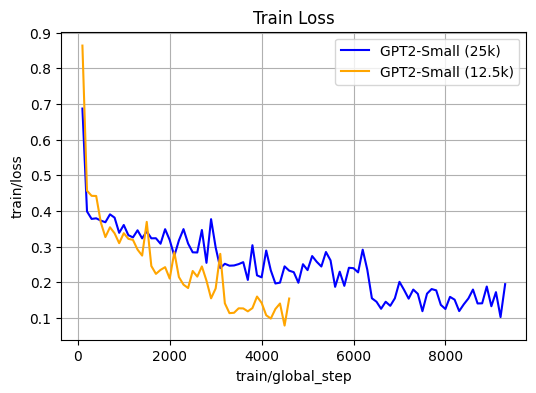

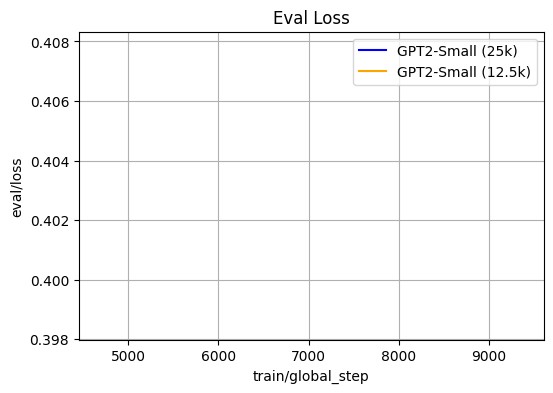

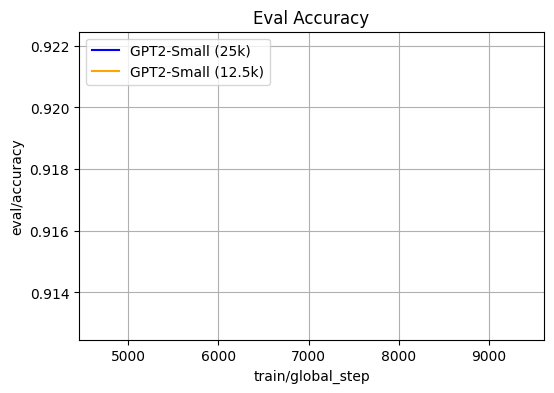

In [21]:
# 📊 Import và định nghĩa các hàm vẽ biểu đồ
import matplotlib.pyplot as plt

def extract_metrics(trainer):
    logs = trainer.state.log_history

    step_train, step_eval = [], []
    train_loss, eval_loss, eval_acc = [], [], []

    for log in logs:
        if "loss" in log and "epoch" in log:
            step_train.append(log["step"])
            train_loss.append(log["loss"])
        if "eval_loss" in log:
            step_eval.append(log["step"])
            eval_loss.append(log["eval_loss"])
        if "eval_accuracy" in log:
            eval_acc.append(log["eval_accuracy"])  # thường đi cùng eval_loss

    return step_train, step_eval, train_loss, eval_loss, eval_acc


def plot_multiline_metrics(trainers, labels, colors):
    # 🎯 Train Loss
    plt.figure(figsize=(6, 4))
    for trainer, label, color in zip(trainers, labels, colors):
        step_train, _, train_loss, _, _ = extract_metrics(trainer)
        plt.plot(step_train, train_loss, label=f"{label}", color=color)
    plt.xlabel("train/global_step")
    plt.ylabel("train/loss")
    plt.title("Train Loss")
    plt.legend()
    plt.grid()
    plt.show()

    # 🎯 Eval Loss
    plt.figure(figsize=(6, 4))
    for trainer, label, color in zip(trainers, labels, colors):
        _, step_eval, _, eval_loss, _ = extract_metrics(trainer)
        plt.plot(step_eval, eval_loss, label=f"{label}", color=color)
    plt.xlabel("train/global_step")
    plt.ylabel("eval/loss")
    plt.title("Eval Loss")
    plt.legend()
    plt.grid()
    plt.show()

    # 🎯 Eval Accuracy
    plt.figure(figsize=(6, 4))
    for trainer, label, color in zip(trainers, labels, colors):
        _, step_eval, _, _, eval_acc = extract_metrics(trainer)
        plt.plot(step_eval, eval_acc, label=f"{label}", color=color)
    plt.xlabel("train/global_step")
    plt.ylabel("eval/accuracy")
    plt.title("Eval Accuracy")
    plt.legend()
    plt.grid()
    plt.show()

# 📈 Gọi vẽ biểu đồ sau khi huấn luyện 2 trainer
plot_multiline_metrics(
    trainers=[trainer_case1, trainer_case2],
    labels=["GPT2-Small (25k)", "GPT2-Small (12.5k)"],
    colors=["blue", "orange"]
)
